In [10]:
"""Plot domain mask with develop environment version"""
import os
import PIL.Image
import numpy as np

def create_domain_mask_develop_png():
    domain_mask_png = "/home/HYDROAPP/develop/wh3248/h4/domain_files/domain_mask.png"
    if not os.path.exists(domain_mask_png):
        raise ValueError(f"{domain_mask_png} does not exist")
    pdata = PIL.Image.open(domain_mask_png)
    ndata = np.array(pdata)
    ndata = np.flip(ndata, 0)
    print(ndata.shape)
    ndata = np.where(ndata == 1, 0, 0xFFFF)
    ndata = ndata.astype(np.uint16)
    img = PIL.Image.fromarray(ndata)
    img = img.resize((ndata.shape[0]*10, ndata.shape[1]*10), PIL.Image.NEAREST)
    return img



In [11]:
"""Plot domain mask with main environment version"""
import os
import PIL.Image
import numpy as np
def create_domain_mask_main_png():
    domain_mask_png = "/home/HYDROAPP/main/wh3248/h4/domain_files/domain_mask.png"
    if not os.path.exists(domain_mask_png):
        raise ValueError(f"{domain_mask_png} does not exist")
    pdata = PIL.Image.open(domain_mask_png)
    ndata = np.array(pdata)
    ndata = np.flip(ndata, 0)
    print(ndata.shape)
    ndata = np.where(ndata == 1, 0, 0xFFFF)
    ndata = ndata.astype(np.uint16)
    img = PIL.Image.fromarray(ndata)
    img = img.resize((260, 230), PIL.Image.NEAREST)
    return img


(26, 23)


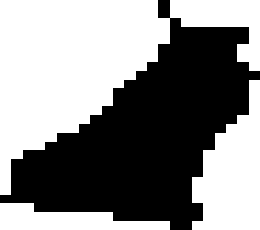

(25, 22)


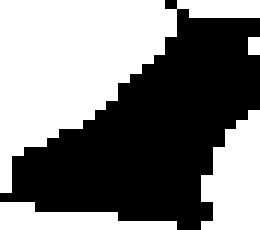

In [12]:
img = create_domain_mask_develop_png()
img.show()
img = create_domain_mask_main_png()
img.show()